### Crispr Amplicon

Read alignment
Consensus 
Visualisation
Stats

In [1]:
import sys
import pysam
import edlib
from collections import Counter

In [2]:
bam = "/mnt/storage1/projects/research/22070I_1057_Cas9-ONT/Sample_22070LRa005/22070LRa005.bam"
bed = "/mnt/storage1/projects/research/22070I_1057_Cas9-ONT/opsin_region.bed"
ref = "/mnt/storage2/megSAP/data/genomes/GRCh38.fa"
fasta_anchors = "anchors.fasta"
outbam = "aln_opsin.test.bam"
outbam_sorted = "aln_opsin.test.sorted.bam"

Read target bedfile

In [3]:
n_window = 100
roi = []
with open(bed)as f:
    for line in f:
        l = line.strip().split()
        l[1] = max(0, int(l[1]) - n_window)
        l[2] = int(l[2]) + n_window
        roi.append(l)
f.close()

roi

[['chrX', 154143338, 154295780]]

Read reference genome

In [4]:
f = pysam.FastaFile(ref)
seq_ref = f.fetch(reference = roi[0][0], start = roi[0][1], end = roi[0][2])
print("Ref Length:", len(seq_ref))

Ref Length: 152442


Read anchors

In [5]:
f_anchors = pysam.FastxFile(fasta_anchors)
for anchor in f_anchors:
    print(anchor.name, ":", anchor.sequence)
f.close()


anchor_BL-715 : GGCAAGGGGGAGGAGGGAAGCCAACAGCAGGATGT
anchor_CHOP_267 : TGGGGGCTAGTGCTGGCACCACCG
anchor_IDT_855 : TGTGCACATGCAAGTCACAAACATTCCAGAT
anchor_CSPO_586 : GGGGCCTGTGGTTGGTGAAGCCCAAGGCA


Read Bamfile

In [6]:
b = pysam.AlignmentFile(bam, "rb")
print("Found", b.count(contig = roi[0][0], start = roi[0][1], end = roi[0][2]), "read alignments")

# Extract from documentation:
# Note that region strings are 1-based, while start and end denote an interval in python coordinates. The region is specified by reference, start and end.
# Todo: Maybe reduce coordinates by 1?
reads = {}
for read in b.fetch(contig = roi[0][0], start = roi[0][1], end = roi[0][2]):
    #print(read.query_name)
    if not read.is_supplementary and not read.is_secondary:
        reads[str(read.query_name)] = {
            'name' : read.query_name, 
            'reference_id'   : read.reference_id,
            'pos'   : read.get_reference_positions(full_length=True),
            'seq_query' : read.query_sequence,
            'pairs' : read.get_aligned_pairs(),
            'strand' : "-" if read.is_reverse else "+",
            'tags' : read.get_tags(),
            'query_qualities': read.query_qualities
        }
b.close()

print("Stored", len(reads), "unique sequences")

Found 289 read alignments
Stored 136 unique sequences


Forward/Reverse sequences:

- `read.querysequence` gives the sequence as stored in the BAMfile, always forward
- `read.get_forward_sequence` gives the original read sequence, i.e reverse complement of the BAM-Seq when on reverse strand

When using the forward `querysequence` we get more matches on the anchor sequences on the reverse strand. Probably they wey defined on the forward strand

Test edlib functionality: Align single read to reference

In [7]:

testread =  next(iter(reads.values()))['seq_query']
print("QRY:", testread)
print("REF:", seq_ref)

QRY: TTATTCACTGTGCTGTGCAGCCATCACCACCATCCAGCCGCAGAACTTGTTCATCTTCCCAAACTGAAGCTCTGGCCCTGTTCAACCCTTAACTCCCACTTCAGCCCCTGGCACCCAATTCTTCCACTGTCTGTCTCTAAGGATTTGACCACTCTAGGCCCTTCATATAAGTGGAATTTACAGTATTTGCCTTCCTGTGACTGGCTCATTTTACTGAGCAATGTCCTCAAGGGTCATTCATGTTGGAGCATGTCAAACTTCATTTCTTTATGGGTGACCTCATATTCCATCGTCTGTATAGACCACAATTTGTGTAGCTAATTCAGTCCGTTGATGTTTGTTGTTGATTTGTTTGTTTATTTTGAGACAGTCTTGCCATCAGAGCTCACTGCAGGCTCAACCTCCCAGGCTCAAGAAATCCTCCCGCTATACCTCCCAAGTAGCTGTGACTACAGGCACCTGACTGTGCCTCTGCTAATTTTTGTATTTTGTAGAGACAGGTCCCACTATGCTGCCCAGGCTAGTCTCGAACTCCTGGGCTCAAGTGATCCTCTCACCTCGCCTCCCAAAGAACTGGGATTACAGGCATGAGCTACTACAACCAGCCCAATTGCCCATTGATGGGCACGGTTGCTTCTGTACCAGCTAAGTTGTGAATCACGCTGCTGTGAACATGCGTAGTAAACAGCCCTTCCAGACCTCAGCCTCCATTCCTCTGGGCCTATACCCAGTAGTGCGGTTGCTGGGTCCTATGGGAATTCTATCGCTTAACTTTGGAGGAGCTACAAACTGTTTTCTCTGTTATGGCTGCGCCTATCACAATCCAATTTTAGGATTACTTTATCACCCATAAAGCACTCCCTGTACCCATACAGTCATCCTCCATTTCCCTCCCTCCTGTCCTGGCACCCATTCCTCTGCTTTGTGTGTCTCTGGATTGCCCTATCTAAGCATTTCACAGAGATGGAGCCATGCGCCCGTGAATCTTAGTCTGG

In [8]:
aln = edlib.align(testread, seq_ref, task="path", mode = "HW")
print(aln)
print(edlib.getNiceAlignment(aln, testread, seq_ref))

{'editDistance': 845, 'alphabetLength': 4, 'locations': [(104351, 105909), (104351, 105914), (104351, 105915)], 'cigar': '2=1I3=2I1=1I1=2I1=3X1=1D5=1D2=1I1=1I2=1X1=1X2=2I6=1D2=2D1=1X3=2X1D3=5I1=2I2=2X1=1I1=1X1=3I2=1I3=1X1I1=1I2=1I4=1I1=1X1=1I1=2D1=1X1I7=1I2=1X1=1X1=3I3=2X1=1D1=1X2=1I2=1X2=1I3=1X1I2=1X2=1X1=1I1=2X1I1=1I1=1I1=1I1=1X1=2X1=1I1=1X1I1=2I2=1I1=2X1=2I2=2I2=2X2=1I1=1X4=3I3=1X3=1X4I1=2I2=1I1=1X1I1=2X4=1X1I1=2X2=1X2I3=2X1I1=1X1=1I2=2X1=1I2=1I1=1X2=1I1=1D3=1X2I2=1X2I3=1X1I5=2I1=1I2=1X1I3=1X1=1X1=9X3=1X2=1I1=1I1=1I1=3I3=3I1=2I1=1I1=1X2=1I1=1X1=1X1=1I1=1I1=6X1=1X2I2=3X1=1X1=1I4=2X3=1X4=1D2=1I10=1X11=1X8=2X4=4D7=1D1=1X1I5=2X21=1D1=1I1=1X1=1D1=2X1D3=1I1=1X10=1D1=1D1=1X4=1D5=1X2=1X2=1D2=1X7=1X10=1X5=1X8=1X7=1X1D1=1I2=1I1=1D1=1X6=1X1D10=2X2=1X11=1X5=2X1=1X2=2X8=1X2=2D2=3X2=1X3=2I2=2X1I2=1I1=1X4=2I2=2X2=1X1=1X1=1I3=2X2=1I1=1I1=2I3=2I1=1I2=2I1=2I1=1X1I1=2I2=1X2=3X2=1D1=1I2=1X1=1X2I2=1I1=1I1=4X2=1X3=1X1I1=1X1=1I2=1X2=1X1=1X1D2=1I3=1D1=1I2=1X2=1I1=1I5=2X1=1X3=2I1=4I1=1X1I1=4I2=1I2=2I3=3I2=4

Test edlib: Align single read to anchor sequence


In [9]:
f_anchors = pysam.FastxFile(fasta_anchors)
anchor1 = next(f_anchors).sequence
f.close()

# Use HW (Infix) mode to find the anchor sequenc
aln = edlib.align(anchor1, testread, task="path", mode =  "HW")
print(aln)
print(edlib.getNiceAlignment(aln, anchor1, testread))


{'editDistance': 12, 'alphabetLength': 4, 'locations': [(1622, 1654)], 'cigar': '2=1I1=1I1=2X4=2D2=1X5=1X1=1D2=1I2=2I6='}
{'query_aligned': 'GGCAAGGGGGAG--GAGGGAAGCC-AACAGCAGGATGT', 'matched_aligned': '||-|-|..||||--||.|||||.|-||-||--||||||', 'target_aligned': 'GG-A-GCTGGAGCTGATGGAAGTCGAA-AG--GGATGT'}


Align all anchors to all reads

In [10]:
anchor_alignments = {}
for read in reads:
    seq = reads[read]['seq_query']
    anchor_alignments[read] = {}
    for anchor in pysam.FastxFile(fasta_anchors):
        aln = edlib.align(anchor.sequence, seq, task="path", mode="HW")
        anchor_alignments[read][anchor.name] = aln

print("Length of anchor table:", len(anchor_alignments))

Length of anchor table: 136


Count anchor matches (Treshold set at 5)

In [11]:
DISTANCE_THRESHOLD= 5
matching_anchors = []
matching_reads = []
for read in anchor_alignments:
    for anchor in anchor_alignments[read]:
        if anchor_alignments[read][anchor]['editDistance'] < DISTANCE_THRESHOLD:
            matching_anchors.append(anchor)
            matching_reads.append(read)

print(Counter(matching_anchors))        # Number of reads per anchor
print(len(Counter(matching_reads)))     # Number of reads with at least 1 anchor
print(Counter(matching_reads))          # Number of anchors per read


Counter({'anchor_CHOP_267': 42, 'anchor_IDT_855': 32, 'anchor_BL-715': 31, 'anchor_CSPO_586': 25})
91
Counter({'2c28252f-5155-43d0-9f36-6532b7c256cc': 2, 'ad78d953-0fb5-4faf-979d-4afe0935a43a': 2, '90ef129f-51a4-472e-886e-a36a7a65aeed': 2, '1e3e71a9-297f-4c80-9312-5a21d643def7': 2, 'a14ed15b-13c9-4bc7-b75e-af70eefea4d5': 2, 'eb89831e-e29b-43de-be56-6035fd33e48e': 2, '7a49d01b-066c-4c73-bf78-4796501bc46b': 2, '41bcd08f-4ae5-4581-b969-2ef8a4fe69b7': 2, 'ed251a40-838d-491f-b6c7-197fcb5ccd36': 2, 'd7cb37e0-1ef0-4e19-a739-95fd0ca2ccb5': 2, '8a64d7d2-c3e9-4884-9082-81b2094c2834': 2, 'dc72fcac-c658-4490-b309-4b3d3d5ffdab': 2, '7c8b0f69-da8d-4e0c-8158-b44ba2aaf76a': 2, '30fceddb-c645-47fb-8a3c-06e088ea26be': 2, '9bd68884-ab3a-4fa2-b320-3feef4dc0dd6': 2, '302e8a1a-0c4f-4705-9295-1830e67dae95': 2, 'c27a5b4a-9c9a-4963-9ff2-edd5465f5032': 2, 'e093a7c4-5be6-4de8-979b-e7e54884eb63': 2, '2ce8c32d-adb5-41d3-9e75-f41e08a9347b': 2, 'bb095ebd-96f3-403f-a9db-87d6b3c201f1': 2, '99336c8b-19c8-40b2-9a0f-2764

## todo: length based edit distance treshold for optimal anchor matching

Reads that match more then one anchor sequence span multiple anchors. To get the correct start position we need to chose the correct anchor sequence as follows: 
 - Take  the anchor with _lowest_ coordinates when on the forward strand
 - Select the anchor with _highest_ coordinates when on the reverse strand

In order to get correct coordinates: 

1) First align anchors to ref genome
2) Extract coordinates
3) Sort anchors matches ascending start
4) Sort anchors matches by descending end

In [12]:
anchors = {}
for anchor in pysam.FastxFile(fasta_anchors):
    
    aln = edlib.align(anchor.sequence, seq_ref, task = "path", mode = "HW")
    if  aln['editDistance'] > 0:
        print("WARNING: no perfect match for ", anchor.name) 
        print("Best anchor match:", aln)

    anchors[anchor.name] = {
        'start': aln['locations'][0][0],
        'end' : aln['locations'][0][1] 
        }

print(anchors)

anchors_sorted_forward = [x[0] for x in sorted(anchors.items(), key=lambda x:x[1]['start'])]
anchors_sorted_reverse = [x[0] for x in sorted(anchors.items(), key=lambda x:x[1]['end'], reverse=True)]

print(anchors_sorted_forward)
print(anchors_sorted_reverse)

{'anchor_BL-715': {'start': 322, 'end': 356}, 'anchor_CHOP_267': {'start': 151726, 'end': 151749}, 'anchor_IDT_855': {'start': 152305, 'end': 152335}, 'anchor_CSPO_586': {'start': 189, 'end': 217}}
['anchor_CSPO_586', 'anchor_BL-715', 'anchor_CHOP_267', 'anchor_IDT_855']
['anchor_IDT_855', 'anchor_CHOP_267', 'anchor_BL-715', 'anchor_CSPO_586']


In [13]:
DISTANCE_THRESHOLD= 5
unique_anchor_alignments = {}

for read in anchor_alignments:
    lowest_anchor_index = 1e5  # Large number
    for anchor in anchor_alignments[read]:
        if anchor_alignments[read][anchor]['editDistance'] < DISTANCE_THRESHOLD:
            
            if reads[read]['strand'] == "+":
                anchor_index = anchors_sorted_forward.index(anchor)
            else :
                anchor_index = anchors_sorted_reverse.index(anchor)            
            if anchor_index < lowest_anchor_index:
                unique_anchor_alignments[read] = anchor

print(unique_anchor_alignments)
print(Counter(unique_anchor_alignments.keys()))
print(Counter(unique_anchor_alignments.values()))

{'2c28252f-5155-43d0-9f36-6532b7c256cc': 'anchor_CSPO_586', 'a016597b-e782-4cea-bf60-a0642c9178f3': 'anchor_CSPO_586', 'a33befdb-842a-444e-93a1-3b45b9f1fad5': 'anchor_CSPO_586', 'ad78d953-0fb5-4faf-979d-4afe0935a43a': 'anchor_CSPO_586', '90ef129f-51a4-472e-886e-a36a7a65aeed': 'anchor_CSPO_586', '1e3e71a9-297f-4c80-9312-5a21d643def7': 'anchor_CSPO_586', '2fffc013-9320-446c-8597-d807f642fd24': 'anchor_CSPO_586', 'ad4a2958-2185-49f4-8c61-5c8275a2e827': 'anchor_CSPO_586', '29422624-886e-484c-9ac0-22c99df2d176': 'anchor_CSPO_586', 'a14ed15b-13c9-4bc7-b75e-af70eefea4d5': 'anchor_CSPO_586', 'eb89831e-e29b-43de-be56-6035fd33e48e': 'anchor_CSPO_586', '7a49d01b-066c-4c73-bf78-4796501bc46b': 'anchor_CSPO_586', 'a9e2c72e-68be-4dff-9a2a-1757f630aea6': 'anchor_CSPO_586', '41bcd08f-4ae5-4581-b969-2ef8a4fe69b7': 'anchor_CSPO_586', 'ed251a40-838d-491f-b6c7-197fcb5ccd36': 'anchor_CSPO_586', '2116532c-5e92-41ec-a770-766a756a4257': 'anchor_CSPO_586', 'd7cb37e0-1ef0-4e19-a739-95fd0ca2ccb5': 'anchor_CSPO_58

Align reads with anchor:

1) Extract positions after/before unique anchor based on strand
2) Prefix alignment of read (with anchor) to the ref sequence. Create reverse sequence for reads on "-" strand
3) Store seq, cigar, positions, strand, subset of read quals in library

In [14]:
reads_aligned = {}

def rev_comp(str):
    return

for read, anchor in unique_anchor_alignments.items():
    print("Aligning:", read, ":", anchor)

    if reads[read]['strand'] == "+":
        seq_from_anchor = reads[read]['seq_query'][anchor_alignments[read][anchor]['locations'][0][0]:]
        qual_from_anchor = reads[read]['query_qualities'][anchor_alignments[read][anchor]['locations'][0][0]:]
        ref_from_anchor = seq_ref[anchors[anchor]['start']:]
    else:
        seq_from_anchor = reads[read]['seq_query'][:anchor_alignments[read][anchor]['locations'][0][1]][::-1]
        qual_from_anchor = reads[read]['query_qualities'][:anchor_alignments[read][anchor]['locations'][0][1]][::-1]
        ref_from_anchor = seq_ref[:anchors[anchor]['end']][::-1]
    
    print("Full read length:", len(reads[read]['seq_query']), "Read length trimmed after anchor:", len(seq_from_anchor))

    aln = edlib.align(seq_from_anchor, ref_from_anchor, task = "path", mode = "SHW")
    aln_nice = edlib.getNiceAlignment(aln, seq_from_anchor, ref_from_anchor)
    ref_length = len(aln_nice['target_aligned'].replace('-', ''))

    reads_aligned[read] = {
        'strand' : reads[read]['strand'],
        'aln' : aln,
        'seq' : seq_from_anchor,
        'ref_length' : ref_length,
        'query_qualities' : qual_from_anchor,
    }

Aligning: 2c28252f-5155-43d0-9f36-6532b7c256cc : anchor_CSPO_586
Full read length: 3354 Read length trimmed after anchor: 3322
Aligning: a016597b-e782-4cea-bf60-a0642c9178f3 : anchor_CSPO_586
Full read length: 1074 Read length trimmed after anchor: 1046
Aligning: a33befdb-842a-444e-93a1-3b45b9f1fad5 : anchor_CSPO_586
Full read length: 21404 Read length trimmed after anchor: 21375
Aligning: ad78d953-0fb5-4faf-979d-4afe0935a43a : anchor_CSPO_586
Full read length: 1984 Read length trimmed after anchor: 1954
Aligning: 90ef129f-51a4-472e-886e-a36a7a65aeed : anchor_CSPO_586
Full read length: 8978 Read length trimmed after anchor: 8946
Aligning: 1e3e71a9-297f-4c80-9312-5a21d643def7 : anchor_CSPO_586
Full read length: 12970 Read length trimmed after anchor: 12938
Aligning: 2fffc013-9320-446c-8597-d807f642fd24 : anchor_CSPO_586
Full read length: 19476 Read length trimmed after anchor: 19443
Aligning: ad4a2958-2185-49f4-8c61-5c8275a2e827 : anchor_CSPO_586
Full read length: 1284 Read length trimm

In [15]:
print(reads_aligned['ad78d953-0fb5-4faf-979d-4afe0935a43a']) #On forward strand 
print(edlib.getNiceAlignment(reads_aligned['ad78d953-0fb5-4faf-979d-4afe0935a43a']['aln'], reads_aligned['ad78d953-0fb5-4faf-979d-4afe0935a43a']['seq'], seq_ref))
print(reads_aligned['3962ce13-eae8-4c3b-95dd-bf7e468572e9']) #On reverse strand
print(edlib.getNiceAlignment(reads_aligned['3962ce13-eae8-4c3b-95dd-bf7e468572e9']['aln'], reads_aligned['3962ce13-eae8-4c3b-95dd-bf7e468572e9']['seq'], seq_ref))

{'strand': '+', 'aln': {'editDistance': 150, 'alphabetLength': 4, 'locations': [(0, 1965), (0, 1966), (0, 1967)], 'cigar': '42=2I9=1D2=1X41=1D2=1I43=1D6=1D19=1D15=4D1=1X19=1D25=1D8=1X8=1I1=2X10=1D5=1D11=1D12=1X1I11=1I38=1D17=1D38=1D7=1D1=1X1I2=1I11=1D20=1I23=2D18=1I10=1I3=1I38=1X13=1I6=1I2=1X1=1D1=1D28=1I6=2D18=1I5=1X1=1I22=1X1I1=3I9=1D2=1I8=1D44=1I7=1X14=1I29=1X1I4=1D2=1D38=1X6=1X1=1I2=1D12=2I1=1X21=1I12=1I2=1D15=1I2=1I1=1I11=1D21=1D3=1D1=1D34=1D1=1D10=1D28=2D81=1D9=1D11=2D61=4I21=1D9=1I16=1I40=1D7=1I15=1X18=1I6=2D30=1D56=1D33=1X1=1D53=2X1=1X2=1X1D1=1D2=3D33=1D9=1I6=3D80=1D2=1X3I63=1I7=1X2=1I2=1D16=2I3=1D21=1X1=1D1=1X1I8=1D6=1I2=1I104=1D15=2I10=1D38=2X8=1I'}, 'seq': 'GGGGCCTGTGGTTGGTGAAGCCCAAGGCAAGGCTGTGAACTCTCAGGGCAAGGAGGCGTGAGCAGGCGCTGCCGTGGGCTGATGTGGGCACTGCATGGCCACCCTGGCGGCCAAAGGACCTACAGCTCATGGGGGGCAAGGGGAGGAGGAAGCCAACAGCAGGATGTGGCAGTCAGTCTGCCCTGCACTGGAGGAGGAGCCCCCGGCACAAATCTCGCCCGTTTGGGCCACGGACATAGCTGGCCTACTTAAGGAGGATCGGTTCAGGCCTCGGCCTAAATAGTCTCCTATGGGCTTTCAAAGAGAACCACATGAGAAAGGAG

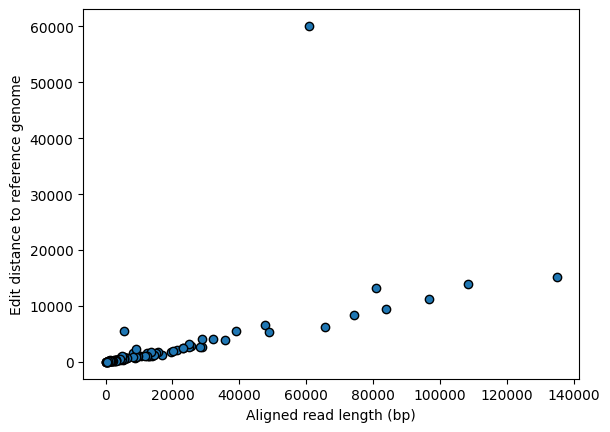

In [16]:
import matplotlib.pyplot as plt

edit_distances = []
matched_query_lengths = []

for read in reads_aligned:
    edit_distances.append(reads_aligned[read]['aln']['editDistance'])
    matched_query_lengths.append(len(reads_aligned[read]['seq']))
print()


plt.scatter(matched_query_lengths, edit_distances, edgecolors='black')
plt.xlabel("Aligned read length (bp)")
plt.ylabel("Edit distance to reference genome")
plt.show()

Alignment looks ok, lets try to create a BAMfile as output

In [17]:
def reverse_cigar(cigarstring): 
    cigar_instructions = []
    n = ""

    for c in cigarstring:
        if c.isnumeric():
            n += c
        else:
            cigar_instructions.append(n +c)
            n = ""

    return "".join(cigar_instructions[::-1])


In [18]:
cigar = reads_aligned[read]['aln']['cigar']
print(cigar)
print(reverse_cigar(cigar))

6=1D6=1X1I11=1X8=2X1I41=1D7=1D2=1D3=1I5=1I1=2D28=1D22=1X11=1D6=1D14=1D6=1X3=2X1I1=1X1=1X4=1I11=1X2=1I2=1X1=1X4=1X1I1=1X1I7=1X1I11=1D31=1D12=1D3=1D2=1X1D1=1X1D6=1X15=1D24=1D5=1I23=1I5=1D6=1I1=1X1=1I1=
1=1I1=1X1=1I6=1D5=1I23=1I5=1D24=1D15=1X6=1D1X1=1D1X2=1D3=1D12=1D31=1D11=1I1X7=1I1X1=1I1X4=1X1=1X2=1I2=1X11=1I4=1X1=1X1=1I2X3=1X6=1D14=1D6=1D11=1X22=1D28=2D1=1I5=1I3=1D2=1D7=1D41=1I2X8=1X11=1I1X6=1D6=


In [19]:
b = pysam.AlignmentFile(bam, "rb")

with pysam.AlignmentFile(outbam, "wb", template = b) as outf:
    for read in reads_aligned:

        if reads_aligned[read]['strand'] == "+" :
            ref_start =  roi[0][1] + anchors[unique_anchor_alignments[read]]['start']
            cigarstring = reads_aligned[read]['aln']['cigar']
            query_sequence = reads_aligned[read]['seq']
        else:
            ref_start = roi[0][1] + anchors[unique_anchor_alignments[read]]['end'] - reads_aligned[read]['ref_length']
            cigarstring = reverse_cigar(reads_aligned[read]['aln']['cigar'])
            query_sequence = reads_aligned[read]['seq'][::-1]
        a = pysam.AlignedSegment()
        a.query_name = read
        a.query_sequence = query_sequence
        a.flag = 0 if reads_aligned[read]['strand'] == "+" else 16
        a.reference_id = reads[read]['reference_id']
        a.reference_start = ref_start
        a.mapping_quality = 30 #Could be adjusted by edit distance ranges
        a.cigarstring = cigarstring
        a.query_qualities = reads_aligned[read]['query_qualities']
        a.tags = reads[read]['tags']

        outf.write(a)

b.close()

In [20]:
pysam.sort("-o", outbam_sorted, outbam)
pysam.index(outbam_sorted)

''

In [21]:
coverages = anchors

for anchor in coverages:
    coverages[anchor]['cov'] = [0]*(roi[0][2] - roi[0][1])

for read in reads_aligned:
    
    if reads_aligned[read]['strand'] == "+" :
        start =  coverages[unique_anchor_alignments[read]]['start']
        end = start + reads_aligned[read]['ref_length']
    else:
        end = coverages[unique_anchor_alignments[read]]['end']
        start = end - reads_aligned[read]['ref_length']    
    
    #print(coverages[unique_anchor_alignments[read]]['cov'])
    for i,n in enumerate(coverages[unique_anchor_alignments[read]]['cov']):
       coverages[unique_anchor_alignments[read]]['cov'][i] = n+1 if start <= i <= end else n


In [22]:
len(coverages['anchor_BL-715']['cov'])

152442

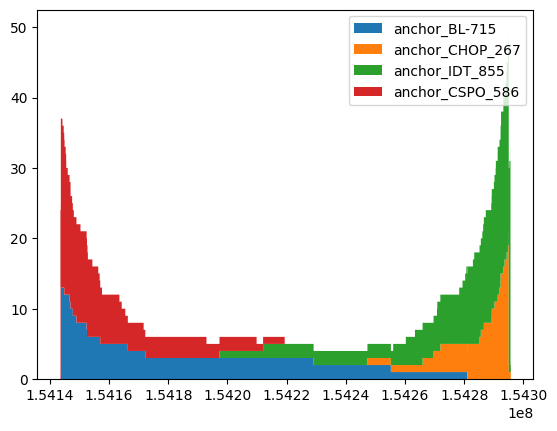

In [51]:
x = range(roi[0][1],roi[0][2])

values = []
labels = []

for i, anchor in enumerate(coverages.keys()):
    values.append(coverages[anchor]['cov'])
    labels.append(anchor)

plt.stackplot(x, values, step='pre', labels=labels)
plt.legend()
plt.show()
